<a href="https://colab.research.google.com/github/liady/dl-ydata/blob/master/svm_exercise_Liad_Yosef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011).
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

# 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)

1. Remember the SVM primal optimization problem in the linearly separable case is defined as
$$
\begin{align}
\min_{\mathbf{w},b}\quad &\frac{\|\mathbf{w}\|}{2}, \\
s.t.\quad&y^{(i)} (\mathbf{w^T}\mathbf{x}^{(i)}+b) \ge 1 &\forall i \in \{1,\dots,N\}
\end{align}
$$
Explain in words why in this case it is **not equivalent** to solve the original problem with a separate bias term $b$, and a reformulation of the problem using a padding of 1 to each sample (effectively ignoring the bias term in the original formulation, and letting the coordinate of $w$ which corresponds to the padding serve as the bias).

2. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.

3. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

4. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

5. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

6. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

###Answer 1
If we pad with 1 - and ignore the bias term - our regularization term will include the "bias weights" as well. As such - the loss could never truly be 0 - (since the weights will have to include the "bias weights" - which are never 0)

###Answer 2

In [0]:
import numpy as np

class PegasosSVM():
  def __init__(self, lambda_=1, T=100):
    self.lambda_ = lambda_
    self.T = T
    self.W = None
    self.converted = False
    
  def fit(self, X, y):
    X_padded = np.pad(X, ((0,0),(1,0)), 'constant', constant_values=1)
    # convert from 1 to -1
    if(0 in y):
      y[y==0] = -1
      self.converted = True
    self.W = np.zeros((X_padded.shape[1],1))
    for t in range(self.T):
      i = np.random.choice(range(X_padded.shape[0]), replace = False)
      etta = 1.0 / (self.lambda_ * (t+1))
      if(y[i]*X_padded[i].dot(self.W) > 1):
        self.W = (1 - 1.0 / (etta * self.lambda_)) * self.W + etta * y[i]*X_padded[i]
      else:
        self.W = (1 - 1.0 / (etta * self.lambda_)) * self.W
   
  def predict(self, X):
    X_padded = np.pad(X, ((0,0),(1,0)), 'constant', constant_values=1)
    y_hat = np.dot(X_padded, self.W)
    y_hat = np.sign(y_hat)
    if(self.converted):
      y_hat[y_hat < 0] = 0
    return y_hat
  
  def decision_function(self, X):
    X_padded = np.pad(X, ((0,0),(1,0)), 'constant', constant_values=1)
    return np.dot(X_padded, self.W)
  
  def score(self, X, y):
    y_hat = self.predict(X)
    return (y_hat == y).sum()/y.shape[0]
    

###Answer 3

In [8]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

bc_data = load_breast_cancer()

pegasos_model = Pipeline([('scaler', StandardScaler()), ("pegasos_svm", PegasosSVM(0.1, bc_data.data.shape[0]*100))])
print('PegasosSVM', 'Cross_val_score mean', cross_val_score(pegasos_model, bc_data.data, bc_data.target, cv=5).mean())  

linear_svc_model = Pipeline([('scaler', StandardScaler()), ("linear_svc", LinearSVC())])
print('LinearSVC', 'Cross_val_score mean', cross_val_score(linear_svc_model, bc_data.data, bc_data.target, cv=5).mean()) 

PegasosSVM Cross_val_score mean 42.4
LinearSVC Cross_val_score mean 0.9667102731819931


For some reason the score is very low in Pegasos

###Answer 4

# 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this create a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

* For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

* Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

* repeat the experiment but now set the `class_weight` to be `balanced`. 

Explain what was the problem and how changing class weight solved it.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
No handles with labels found to put in legend.


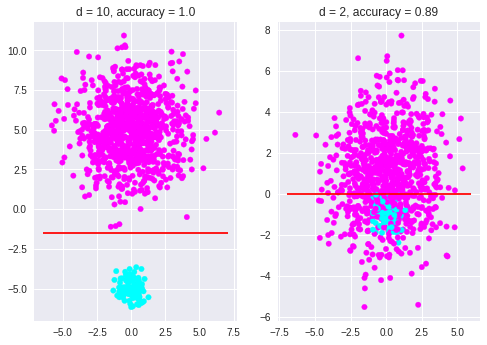

In [16]:
import matplotlib.pyplot as plt

def make_data(n_samples=1000, imbalance=0.1, d=10):
  Y = (np.random.random_sample((n_samples, 1)) > imbalance).astype(int)
  sigma = 1/2 + 3/2*Y
  mu = np.hstack((np.zeros((n_samples, 1)),(d*(Y-1/2))))
  return sigma * np.random.randn(n_samples,2) + mu, Y

plt.subplot(1,2,1)
X,Y = make_data(d=10)
model = LinearSVC()
model.fit(X,Y)
plt.scatter(X[:, 0], X[:, 1], c=Y.reshape(-1), s=30, cmap='cool')
plt.hlines(-3/2, *plt.xlim(), color='r')

XX,YY = np.meshgrid(plt.xlim(), plt.ylim())
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)
plt.title('d = 10, accuracy = ' + str(model.score(X,Y)))
plt.legend()

plt.subplot(1,2,2)
X,Y = make_data(d=2)
model = LinearSVC()
model.fit(X,Y)
plt.scatter(X[:, 0], X[:, 1], c=Y.reshape(-1), s=30, cmap='cool')
plt.hlines(0, *plt.xlim(), color='r')

XX,YY = np.meshgrid(plt.xlim(), plt.ylim())
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)
plt.title('d = 2, accuracy = ' + str(model.score(X,Y)))
plt.legend()

#3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.


In [19]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'multi_class': ['ovr', 'crammer_singer'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.logspace(-3, 3, 10)}

scaler = StandardScaler()
X, Y = scaler.fit_transform(bc_data.data), bc_data.target

default_model = LinearSVC()
optimized_model = GridSearchCV(LinearSVC(), parameters, cv=5)
optimized_model.fit(X,Y)

default_model_score=cross_val_score(default_model, X, Y, cv=5)
optimized_model_score=cross_val_score(optimized_model, X, Y, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


['mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score', 'param_C', 'param_loss', 'param_multi_class', 'params', 'rank_test_score', 'split0_test_score', 'split0_train_score', 'split1_test_score', 'split1_train_score', 'split2_test_score', 'split2_train_score', 'split3_test_score', 'split3_train_score', 'split4_test_score', 'split4_train_score', 'std_fit_time', 'std_score_time', 'std_test_score', 'std_train_score']
default_model score= 0.9667102731819931
optimized_model score= 0.9789149672951135


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [20]:
print('default_model score =', default_model_score.mean(), '; optimized_model score =', optimized_model_score.mean())

default_model score = 0.9667102731819931 ; optimized_model score = 0.9789149672951135


# 4. Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

